In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
df = pd.read_excel('/kaggle/input/vikassirdataset/New Power.xlsx',sheet_name="Sheet1")
df.head()


,DATE,NET_P,StnPres
0,2019-05-03 00:00:00,0.0,1009.1
1,2019-05-03 00:15:00,0.0,1009.1
2,2019-05-03 00:30:00,0.0,1009.1
3,2019-05-03 00:45:00,0.0,1009.1
4,2019-05-03 01:00:00,0.0,1008.8


In [2]:

df = pd.read_excel('/kaggle/input/vikassirdataset/New Power.xlsx',sheet_name="Sheet1")
df['DATE'] = pd.to_datetime(df['DATE'])

# df['timestamp'] = pd.date_range(start="2024-01-01", periods=len(df), freq="15min")
# df.set_index('timestamp', inplace=True)
df = df.sort_values(by='DATE')
features = ['NET_P', 'StnPres']
df = df[["DATE"] + features]
print(df.head())


                 DATE  NET_P  StnPres
0 2019-05-03 00:00:00    0.0   1009.1
1 2019-05-03 00:15:00    0.0   1009.1
2 2019-05-03 00:30:00    0.0   1009.1
3 2019-05-03 00:45:00    0.0   1009.1
4 2019-05-03 01:00:00    0.0   1008.8


In [3]:

scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
# df[['NET_P', 'StnPres']] = scaler.fit_transform(df[['NET_P', 'StnPres']])
df['lag_1'] = df['NET_P'].shift(1)
df['lag_2'] = df['NET_P'].shift(2)
df.dropna(inplace=True)

In [4]:
train_size = int(len(df) * 0.8)  # 80% training, 20% testing
train, test = df.iloc[:train_size], df.iloc[train_size:]
def create_sequences(data, target_col, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length][['NET_P', 'StnPres']].values)
        y.append(data.iloc[i+seq_length][target_col])
    return np.array(X), np.array(y)

seq_length = 10
X_train, y_train = create_sequences(train, target_col='NET_P', seq_length=seq_length)
X_test, y_test = create_sequences(test, target_col='NET_P', seq_length=seq_length)

In [5]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 2)),
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=16, 
                    validation_data=(X_test, y_test), callbacks=[early_stopping])
y_pred = model.predict(X_test)

# Reverse Scaling
y_test_actual = scaler.inverse_transform(np.column_stack((y_test, np.zeros_like(y_test))))
y_pred_actual = scaler.inverse_transform(np.column_stack((y_pred.flatten(), np.zeros_like(y_pred.flatten()))))

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0384 - val_loss: 0.0267
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0174 - val_loss: 0.0214
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0181 - val_loss: 0.0212
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0158 - val_loss: 0.0148
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0138 - val_loss: 0.0105
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0094 - val_loss: 0.0090
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0088 - val_loss: 0.0085
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0092 - val_loss: 0.0073
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0093 - val_loss: 0.0080
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0104 - val_loss: 0.0069
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0086 - val_loss: 0.0068
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0084 - val_l

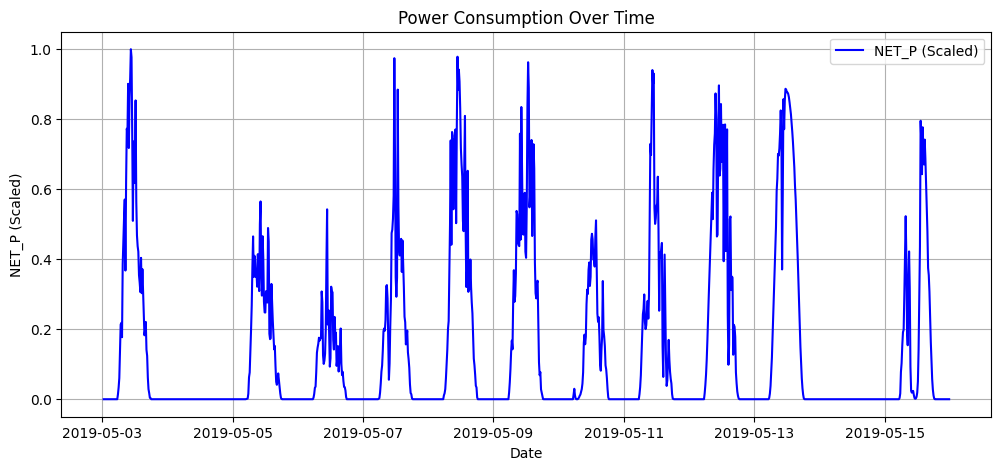

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(df['DATE'], df['NET_P'], label="NET_P (Scaled)", color="blue")
plt.xlabel("Date")
plt.ylabel("NET_P (Scaled)")
plt.title("Power Consumption Over Time")
plt.legend()
plt.grid()
plt.show()


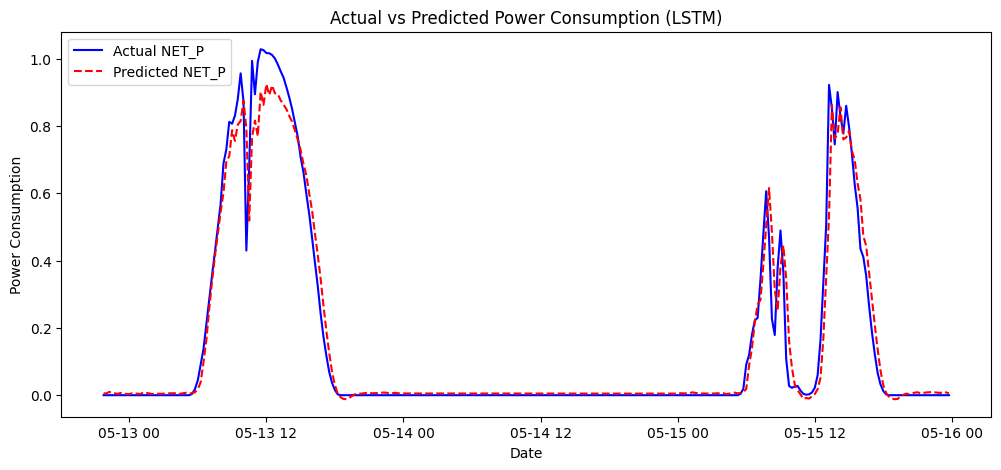

In [7]:
plt.figure(figsize=(12, 5))
plt.plot(df['DATE'].iloc[train_size + seq_length:], y_test_actual[:, 0], label="Actual NET_P", color="blue")
plt.plot(df['DATE'].iloc[train_size + seq_length:], y_pred_actual[:, 0], label="Predicted NET_P", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Power Consumption")
plt.title("Actual vs Predicted Power Consumption (LSTM)")
plt.legend()
plt.show()


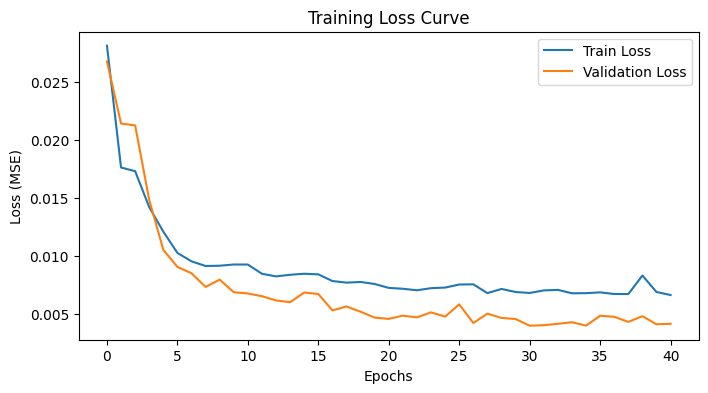

In [8]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

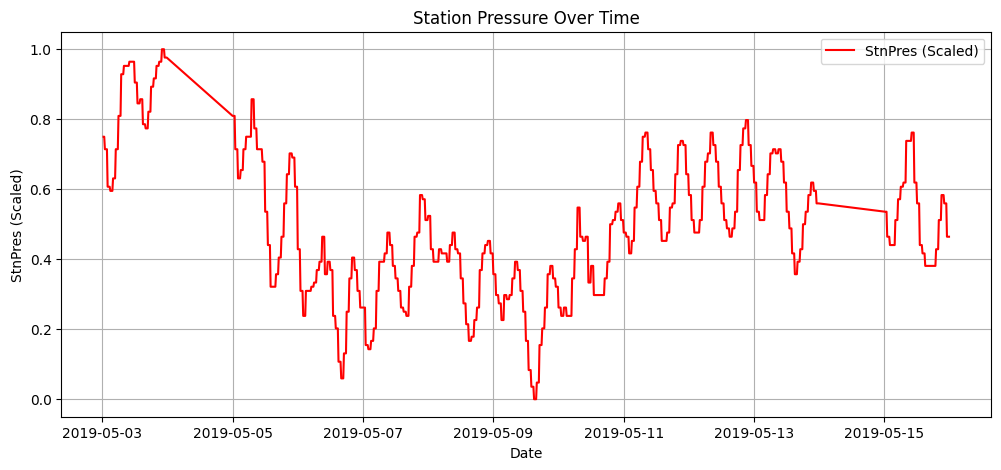

In [9]:
plt.figure(figsize=(12, 5))
plt.plot(df['DATE'], df['StnPres'], label="StnPres (Scaled)", color="red")
plt.xlabel("Date")
plt.ylabel("StnPres (Scaled)")
plt.title("Station Pressure Over Time")
plt.legend()
plt.grid()
plt.show()

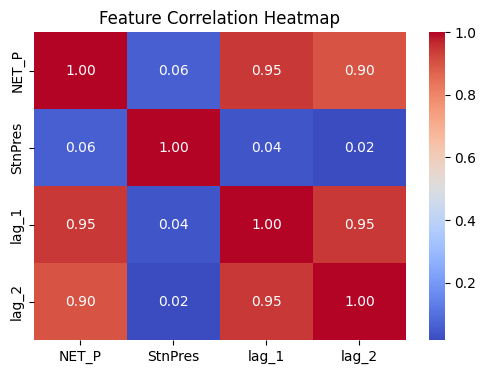

In [10]:
plt.figure(figsize=(6, 4))
sns.heatmap(df[['NET_P', 'StnPres', 'lag_1', 'lag_2']].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


In [11]:
y_test_inv = scaler.inverse_transform(np.column_stack((y_test, np.zeros_like(y_test))))
y_pred_inv = scaler.inverse_transform(np.column_stack((y_pred.flatten(), np.zeros_like(y_pred.flatten()))))


In [12]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test_inv[:, 0], y_pred_inv[:, 0])
print(f"Mean Squared Error (MSE): {mse:.4f}")


Mean Squared Error (MSE): 0.0054
